# Define homology gene set for human, mouse and zebrafish

In [ ]:
this scrapes the ensembl FTP for all available
# get all the stuff from ensembl
import requests
import re
import urllib
import time


species_regex = re.compile('href=\"([a-z_]+)/\"')
file_regex = re.compile('href=\"(.+fa\.gz)\"')

release = 'release-113'
fasta = requests.get(f'https://ftp.ensembl.org/pub/{release}/fasta/')

species_to_download = ['homo_sapiens', 'mus_musculus', 'danio_rerio']
for species in species_regex.findall(fasta.text):
    if not species in species_to_download:
        continue
        
    r = requests.get(f'https://ftp.ensembl.org/pub/{release}/fasta/{species}/cds/')
    match = file_regex.search(r.text)
    
    if not match:
        continue
        
    file = match.groups()[0]
    time.sleep(0.5)
    print(f'retrieving {file} for {species}')
    urllib.request.urlretrieve(
        f'https://ftp.ensembl.org/pub/{release}/fasta/{species}/cds/{file}', 
        f'../cds/{file}'
    )
    cds_files[species] = f'../cds/{file}'
    time.sleep(1)

In [ ]:
from codontools import io

# downloaded from ensembl
cds_files = {
    'zebrafish': '../cds/Danio_rerio.GRCz11.cds.all.fa.gz',
    'mouse': '../cds/Mus_musculus.GRCm39.cds.all.fa.gz',
    'human': '../cds/Homo_sapiens.GRCh38.cds.all.fa.gz'
}

filter_dict = {
    'transcript_biotype': 'protein_coding',
    'gene_biotype': 'protein_coding'
}

cds_frames = {
    species: io.read_cds_fasta(filename, filter_dict) 
    for species, filename 
    in cds_files.items()
}
cds_frames

In [ ]:
def keep_longest(transcripts):
    column_subset = transcripts.loc[:, ['gene_id', 'sequence']]
    column_subset['transcript_length'] = column_subset.sequence.str.len()
    longest_idx = column_subset.groupby('gene_id').apply(
        lambda x: x['transcript_length'].idxmax()
    )
    return transcripts.loc[longest_idx, :]

longest_cds = {
    key: keep_longest(frame) for key, frame in cds_frames.items()
}
longest_cds

In [ ]:
for frame in longest_cds.values():
    frame['unversioned_gene_id'] = frame.gene_id.apply(
        lambda x: x.split('.')[0]
    )
    
cds_frames

In [ ]:
from gseapy import Biomart

bm = Biomart()
m2h = bm.query(
    dataset='mmusculus_gene_ensembl',
    attributes=[
        'ensembl_gene_id',
        'external_gene_name',
        'hsapiens_homolog_ensembl_gene',
        'hsapiens_homolog_associated_gene_name'
    ]
)
d2h = bm.query(
    dataset='drerio_gene_ensembl',
    attributes=[
        'ensembl_gene_id',
        'external_gene_name',
        'hsapiens_homolog_ensembl_gene',
        'hsapiens_homolog_associated_gene_name'
    ]
)

In [7]:
has_human_homolog_mouse = ~m2h.hsapiens_homolog_ensembl_gene.isna()
use_cols = ['ensembl_gene_id', 'external_gene_name', 'hsapiens_homolog_ensembl_gene', ]
homology_frame = m2h.loc[has_human_homolog_mouse, ].merge(
    d2h,
    on = ['hsapiens_homolog_ensembl_gene', 'hsapiens_homolog_associated_gene_name'],
    how = 'inner',
    suffixes = ['_mouse', '_zebrafish']
)
homology_frame.rename(
    columns = {
        'hsapiens_homolog_associated_gene_name': 'external_gene_name_human',
        'hsapiens_homolog_ensembl_gene': 'ensembl_gene_id_human'
    },
    inplace = True
)
homology_frame

,ensembl_gene_id_mouse,external_gene_name_mouse,ensembl_gene_id_human,external_gene_name_human,ensembl_gene_id_zebrafish,external_gene_name_zebrafish
0,ENSMUSG00000064341,mt-Nd1,ENSG00000198888,MT-ND1,ENSDARG00000063895,MT-ND1
1,ENSMUSG00000064345,mt-Nd2,ENSG00000198763,MT-ND2,ENSDARG00000063899,MT-ND2
2,ENSMUSG00000064351,mt-Co1,ENSG00000198804,MT-CO1,ENSDARG00000063905,MT-CO1
3,ENSMUSG00000064354,mt-Co2,ENSG00000198712,MT-CO2,ENSDARG00000063908,MT-CO2
4,ENSMUSG00000064357,mt-Atp6,ENSG00000198899,MT-ATP6,ENSDARG00000063911,MT-ATP6
...,...,...,...,...,...,...
24475,ENSMUSG00000051149,Adnp,ENSG00000101126,ADNP,ENSDARG00000074293,ADNP
24476,ENSMUSG00000051149,Adnp,ENSG00000101126,ADNP,ENSDARG00000062002,ADNP
24477,ENSMUSG00000078919,Dpm1,ENSG00000000419,DPM1,ENSDARG00000057011,DPM1
24478,ENSMUSG00000074576,Mocs3,ENSG00000124217,MOCS3,ENSDARG00000008239,MOCS3


In [8]:
homology_frame.to_csv(
    '../cds/ensembl_homologies.tsv',
    sep = '\t',
    index = False
)

In [9]:
homolog_cds_only = {}
for key, frame in longest_cds.items():
    homology_subset = homology_frame.loc[
        :, 
        [f'ensembl_gene_id_{key}', 'ensembl_gene_id_human']
    ]
    homology_subset.columns = ['unversioned_gene_id', 'ensembl_gene_id_human']
    homologs_only = frame.merge(
        homology_subset,
        on = 'unversioned_gene_id',
        how = 'inner'
    )
    homolog_cds_only[key] = homologs_only.drop_duplicates().reset_index(drop = True)
    
homolog_cds_only

{'zebrafish':       transcript_biotype    gene_biotype               gene_id gene_symbol  \
 0         protein_coding  protein_coding  ENSDARG00000000001.6     slc35a5   
 1         protein_coding  protein_coding  ENSDARG00000000018.9        nrf1   
 2         protein_coding  protein_coding  ENSDARG00000000019.9       ube2h   
 3         protein_coding  protein_coding  ENSDARG00000000068.9   slc9a3r1a   
 4         protein_coding  protein_coding  ENSDARG00000000069.7         dap   
 ...                  ...             ...                   ...         ...   
 18953     protein_coding  protein_coding  ENSDARG00000117093.1      dipk1b   
 18954     protein_coding  protein_coding  ENSDARG00000117130.1  BX936439.1   
 18955     protein_coding  protein_coding  ENSDARG00000117133.1    cst14b.1   
 18956     protein_coding  protein_coding  ENSDARG00000117145.1     notum1b   
 18957     protein_coding  protein_coding  ENSDARG00000117193.1  FO704607.1   
 
               transcript_id  \
 0   

In [10]:
from functools import reduce

frames = []
for key, frame in homolog_cds_only.items():
    columns = ['gene_id', 'gene_symbol', 'transcript_id', 'sequence', 'unversioned_gene_id', 'ensembl_gene_id_human']
    column_subset = frame.loc[:, columns]
    column_subset.columns = [f'{c}_{key}' for c in columns[:-1]] + [columns[-1]]
    frames.append(column_subset)
    
homologs = reduce(
    lambda x, y: x.merge(y, on = 'ensembl_gene_id_human', how = 'inner'),
    frames
)
homologs

,gene_id_zebrafish,gene_symbol_zebrafish,transcript_id_zebrafish,sequence_zebrafish,unversioned_gene_id_zebrafish,ensembl_gene_id_human,gene_id_mouse,gene_symbol_mouse,transcript_id_mouse,sequence_mouse,unversioned_gene_id_mouse,gene_id_human,gene_symbol_human,transcript_id_human,sequence_human,unversioned_gene_id_human
0,ENSDARG00000000001.6,slc35a5,ENSDART00000000004.5,ATGTCCTTCACAATGGCACGATACTCCTCTTCCTCGTCGTCTGCTT...,ENSDARG00000000001,ENSG00000138459,ENSMUSG00000022664.12,Slc35a5,ENSMUST00000023344.10,ATGAAAGTGATCTTCTTAAGGCAATTAAAAACCCGTGGAATGGAAA...,ENSMUSG00000022664,ENSG00000138459.9,SLC35A5,ENST00000492406.6,ATGGAAAAACAGTGCTGTAGTCATCCTGTAATATGCTCCTTGTCAA...,ENSG00000138459
1,ENSDARG00000000018.9,nrf1,ENSDART00000181044.1,ATGGAAGACCATACGGTGCATCAGACGGAGCATATGACCACTATCG...,ENSDARG00000000018,ENSG00000106459,ENSMUSG00000058440.15,Nrf1,ENSMUST00000115206.8,ATGGAGGAGCACGGAGTGACCCAAACTGAACACATGGCTACCATAG...,ENSMUSG00000058440,ENSG00000106459.15,NRF1,ENST00000311967.6,ATGGAGGAACACGGAGTGACCCAAACCGAACATATGGCTACCATAG...,ENSG00000106459
2,ENSDARG00000000019.9,ube2h,ENSDART00000124452.3,ATGTCGTCTCCAAGTCCGGGCAAAAGACGAATGGACACCGACGTGG...,ENSDARG00000000019,ENSG00000186591,ENSMUSG00000039159.17,Ube2h,ENSMUST00000102993.10,ATGTCATCCCCCAGTCCCGGCAAGAGGCGGATGGACACGGACGTAG...,ENSMUSG00000039159,ENSG00000186591.13,UBE2H,ENST00000355621.8,ATGTCATCTCCCAGTCCGGGCAAGAGGCGGATGGACACGGACGTGG...,ENSG00000186591
3,ENSDARG00000000068.9,slc9a3r1a,ENSDART00000000069.8,ATGTCCAGCGACCTCAGGCCAAAGCTGTGCGTCTTAGAAAAAGGGG...,ENSDARG00000000068,ENSG00000109062,ENSMUSG00000020733.4,Nherf1,ENSMUST00000021077.4,ATGAGCGCGGACGCAGCGGCCGGGGAGCCTCTGCCCCGGCTCTGCT...,ENSMUSG00000020733,ENSG00000109062.12,NHERF1,ENST00000262613.10,ATGAGCGCGGACGCAGCGGCCGGGGCGCCCCTGCCCCGGCTCTGCT...,ENSG00000109062
4,ENSDARG00000000069.7,dap,ENSDART00000000070.7,ATGTCATCGCCGCCCAAAGAGAAAACCGAGACCAGAGCTGGTCACC...,ENSDARG00000000069,ENSG00000112977,ENSMUSG00000039168.16,Dap,ENSMUST00000044524.16,ATGTCTTCGCCTCCAGAAGGAAAGCTGGAGACCAAAGCTGGACACC...,ENSMUSG00000039168,ENSG00000112977.16,DAP,ENST00000432074.2,ATGTCTTCGCCTCCCGAAGGGAAACTAGAGACTAAAGCTGGACACC...,ENSG00000112977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23023,ENSDARG00000117133.1,cst14b.1,ENSDART00000192398.1,ATGGCAACTAAAAAAGTTGGAGGTCAATCGGAGGAAAAACAGGCCA...,ENSDARG00000117133,ENSG00000121552,ENSMUSG00000079597.3,Cstdc4,ENSMUST00000114858.2,ATGATGCCTGGAGGCTTGTCACGGGCCAGATCTGCCACACCAGAAA...,ENSMUSG00000079597,ENSG00000121552.4,CSTA,ENST00000264474.4,ATGATACCTGGAGGCTTATCTGAGGCCAAACCCGCCACTCCAGAAA...,ENSG00000121552
23024,ENSDARG00000117133.1,cst14b.1,ENSDART00000192398.1,ATGGCAACTAAAAAAGTTGGAGGTCAATCGGAGGAAAAACAGGCCA...,ENSDARG00000117133,ENSG00000121552,ENSMUSG00000094733.2,Csta3,ENSMUST00000089628.4,ATGATTCTCGGAGGTGTTTCAGAGGCAAGACCTGCCACACCAGAAA...,ENSMUSG00000094733,ENSG00000121552.4,CSTA,ENST00000264474.4,ATGATACCTGGAGGCTTATCTGAGGCCAAACCCGCCACTCCAGAAA...,ENSG00000121552
23025,ENSDARG00000117133.1,cst14b.1,ENSDART00000192398.1,ATGGCAACTAAAAAAGTTGGAGGTCAATCGGAGGAAAAACAGGCCA...,ENSDARG00000117133,ENSG00000121552,ENSMUSG00000095620.8,Csta2,ENSMUST00000187183.7,ATGATGCCTGGAGGCTTGTCACGGGCCAGATCTGCCACACCAGAAA...,ENSMUSG00000095620,ENSG00000121552.4,CSTA,ENST00000264474.4,ATGATACCTGGAGGCTTATCTGAGGCCAAACCCGCCACTCCAGAAA...,ENSG00000121552
23026,ENSDARG00000117145.1,notum1b,ENSDART00000192270.1,TCAGGAACTGGGATTCTGTCTCCACAACCAGAGGAAAATCCTCACT...,ENSDARG00000117145,ENSG00000185269,ENSMUSG00000042988.11,Notum,ENSMUST00000106177.8,ATGGGAGGAGAGGTGCGCGTGCTGCTACTGCTGGGCCTGCTGCATT...,ENSMUSG00000042988,ENSG00000185269.12,NOTUM,ENST00000409678.8,ATGGGCCGAGGGGTGCGCGTGCTGCTGCTGCTGAGCCTGCTGCACT...,ENSG00000185269


In [9]:
homologs.to_csv(
    '../cds/all_homologs.tsv',
    sep = '\t',
    index = False
)

# Count codons

In [11]:
import pandas as pd


taxons = ['zebrafish', 'mouse', 'human']
homologs = pd.read_csv(
    '../cds/all_homologs.tsv',
    sep = '\t'
)
homologs

,gene_id_zebrafish,gene_symbol_zebrafish,transcript_id_zebrafish,sequence_zebrafish,unversioned_gene_id_zebrafish,ensembl_gene_id_human,gene_id_mouse,gene_symbol_mouse,transcript_id_mouse,sequence_mouse,unversioned_gene_id_mouse,gene_id_human,gene_symbol_human,transcript_id_human,sequence_human,unversioned_gene_id_human
0,ENSDARG00000000001.6,slc35a5,ENSDART00000000004.5,ATGTCCTTCACAATGGCACGATACTCCTCTTCCTCGTCGTCTGCTT...,ENSDARG00000000001,ENSG00000138459,ENSMUSG00000022664.12,Slc35a5,ENSMUST00000023344.10,ATGAAAGTGATCTTCTTAAGGCAATTAAAAACCCGTGGAATGGAAA...,ENSMUSG00000022664,ENSG00000138459.9,SLC35A5,ENST00000492406.6,ATGGAAAAACAGTGCTGTAGTCATCCTGTAATATGCTCCTTGTCAA...,ENSG00000138459
1,ENSDARG00000000018.9,nrf1,ENSDART00000181044.1,ATGGAAGACCATACGGTGCATCAGACGGAGCATATGACCACTATCG...,ENSDARG00000000018,ENSG00000106459,ENSMUSG00000058440.15,Nrf1,ENSMUST00000115206.8,ATGGAGGAGCACGGAGTGACCCAAACTGAACACATGGCTACCATAG...,ENSMUSG00000058440,ENSG00000106459.15,NRF1,ENST00000311967.6,ATGGAGGAACACGGAGTGACCCAAACCGAACATATGGCTACCATAG...,ENSG00000106459
2,ENSDARG00000000019.9,ube2h,ENSDART00000124452.3,ATGTCGTCTCCAAGTCCGGGCAAAAGACGAATGGACACCGACGTGG...,ENSDARG00000000019,ENSG00000186591,ENSMUSG00000039159.17,Ube2h,ENSMUST00000102993.10,ATGTCATCCCCCAGTCCCGGCAAGAGGCGGATGGACACGGACGTAG...,ENSMUSG00000039159,ENSG00000186591.13,UBE2H,ENST00000355621.8,ATGTCATCTCCCAGTCCGGGCAAGAGGCGGATGGACACGGACGTGG...,ENSG00000186591
3,ENSDARG00000000068.9,slc9a3r1a,ENSDART00000000069.8,ATGTCCAGCGACCTCAGGCCAAAGCTGTGCGTCTTAGAAAAAGGGG...,ENSDARG00000000068,ENSG00000109062,ENSMUSG00000020733.4,Nherf1,ENSMUST00000021077.4,ATGAGCGCGGACGCAGCGGCCGGGGAGCCTCTGCCCCGGCTCTGCT...,ENSMUSG00000020733,ENSG00000109062.12,NHERF1,ENST00000262613.10,ATGAGCGCGGACGCAGCGGCCGGGGCGCCCCTGCCCCGGCTCTGCT...,ENSG00000109062
4,ENSDARG00000000069.7,dap,ENSDART00000000070.7,ATGTCATCGCCGCCCAAAGAGAAAACCGAGACCAGAGCTGGTCACC...,ENSDARG00000000069,ENSG00000112977,ENSMUSG00000039168.16,Dap,ENSMUST00000044524.16,ATGTCTTCGCCTCCAGAAGGAAAGCTGGAGACCAAAGCTGGACACC...,ENSMUSG00000039168,ENSG00000112977.16,DAP,ENST00000432074.2,ATGTCTTCGCCTCCCGAAGGGAAACTAGAGACTAAAGCTGGACACC...,ENSG00000112977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21234,ENSDARG00000117133.1,cst14b.1,ENSDART00000192398.1,ATGGCAACTAAAAAAGTTGGAGGTCAATCGGAGGAAAAACAGGCCA...,ENSDARG00000117133,ENSG00000121552,ENSMUSG00000079597.3,Cstdc4,ENSMUST00000114858.2,ATGATGCCTGGAGGCTTGTCACGGGCCAGATCTGCCACACCAGAAA...,ENSMUSG00000079597,ENSG00000121552.4,CSTA,ENST00000264474.4,ATGATACCTGGAGGCTTATCTGAGGCCAAACCCGCCACTCCAGAAA...,ENSG00000121552
21235,ENSDARG00000117133.1,cst14b.1,ENSDART00000192398.1,ATGGCAACTAAAAAAGTTGGAGGTCAATCGGAGGAAAAACAGGCCA...,ENSDARG00000117133,ENSG00000121552,ENSMUSG00000094733.2,Csta3,ENSMUST00000089628.4,ATGATTCTCGGAGGTGTTTCAGAGGCAAGACCTGCCACACCAGAAA...,ENSMUSG00000094733,ENSG00000121552.4,CSTA,ENST00000264474.4,ATGATACCTGGAGGCTTATCTGAGGCCAAACCCGCCACTCCAGAAA...,ENSG00000121552
21236,ENSDARG00000117133.1,cst14b.1,ENSDART00000192398.1,ATGGCAACTAAAAAAGTTGGAGGTCAATCGGAGGAAAAACAGGCCA...,ENSDARG00000117133,ENSG00000121552,ENSMUSG00000095620.8,Csta2,ENSMUST00000187183.7,ATGATGCCTGGAGGCTTGTCACGGGCCAGATCTGCCACACCAGAAA...,ENSMUSG00000095620,ENSG00000121552.4,CSTA,ENST00000264474.4,ATGATACCTGGAGGCTTATCTGAGGCCAAACCCGCCACTCCAGAAA...,ENSG00000121552
21237,ENSDARG00000117145.1,notum1b,ENSDART00000192270.1,TCAGGAACTGGGATTCTGTCTCCACAACCAGAGGAAAATCCTCACT...,ENSDARG00000117145,ENSG00000185269,ENSMUSG00000042988.11,Notum,ENSMUST00000106177.8,ATGGGAGGAGAGGTGCGCGTGCTGCTACTGCTGGGCCTGCTGCATT...,ENSMUSG00000042988,ENSG00000185269.12,NOTUM,ENST00000409678.8,ATGGGCCGAGGGGTGCGCGTGCTGCTGCTGCTGAGCCTGCTGCACT...,ENSG00000185269


In [12]:
from codontools import count

codon_counts, codon_frequencies, = {}, {}
for taxon in taxons:
    columns = ['transcript_id', 'sequence']
    cds_frame = homologs.loc[:, [c + f'_{taxon}' for c in columns]]
    cds_frame.columns = columns
    cds_frame.drop_duplicates(inplace = True)
    cds_frame.set_index('transcript_id', inplace = True)
    counts = count.count_codons_per_cds(cds_frame.sequence)
    frequencies = counts.divide(
        counts.sum(axis=1), 
        axis=0
    )
    codon_counts[taxon] = counts
    codon_frequencies[taxon] = frequencies
    
codon_counts

{'zebrafish':                       AAA  AAC  AAG  AAT  ACA  ACC  ACG  ACT  AGA  AGC  ...  \
 ENSDART00000000004.5    5    8   10   10    9    5    2    3    3    9  ...   
 ENSDART00000181044.1    7    6   10    7   22    9   11   12    4    5  ...   
 ENSDART00000124452.3    8    5    5    2    4    4    0    0    1    1  ...   
 ENSDART00000000069.8   17   10   14    6    5   10    0    2    5    8  ...   
 ENSDART00000000070.7    7    1    6    0    1    3    0    2    1    0  ...   
 ...                   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
 ENSDART00000187467.1    9    8   13    4    5    3    4    7    7    7  ...   
 ENSDART00000183924.1    4    6    8    1    4    1    3    2    3    6  ...   
 ENSDART00000192398.1    6    1    6    1    1    2    0    4    1    0  ...   
 ENSDART00000192270.1    0    3    1    1    1    0    0    3    1    1  ...   
 ENSDART00000185804.1    2    6    2    3    3    4    5    2    2    5  ...   
 
                       TC

# Find clusters of codons of interest

In [15]:
codons_of_interest_G = ['AAG', 'GAG', 'CAG', 'AGG']
codons_of_interest_A = ['AAA', 'GAA', 'CAA', 'AGA']
codons_of_interest = codons_of_interest_G + codons_of_interest_A

In [13]:
taxon = 'mouse'
columns = ['transcript_id', 'sequence']
cds_frame = homologs.loc[:, [c + f'_{taxon}' for c in columns]]
cds_frame

,transcript_id_mouse,sequence_mouse
0,ENSMUST00000023344.10,ATGAAAGTGATCTTCTTAAGGCAATTAAAAACCCGTGGAATGGAAA...
1,ENSMUST00000115206.8,ATGGAGGAGCACGGAGTGACCCAAACTGAACACATGGCTACCATAG...
2,ENSMUST00000102993.10,ATGTCATCCCCCAGTCCCGGCAAGAGGCGGATGGACACGGACGTAG...
3,ENSMUST00000021077.4,ATGAGCGCGGACGCAGCGGCCGGGGAGCCTCTGCCCCGGCTCTGCT...
4,ENSMUST00000044524.16,ATGTCTTCGCCTCCAGAAGGAAAGCTGGAGACCAAAGCTGGACACC...
...,...,...
21326,ENSMUST00000114858.2,ATGATGCCTGGAGGCTTGTCACGGGCCAGATCTGCCACACCAGAAA...
21327,ENSMUST00000089628.4,ATGATTCTCGGAGGTGTTTCAGAGGCAAGACCTGCCACACCAGAAA...
21328,ENSMUST00000187183.7,ATGATGCCTGGAGGCTTGTCACGGGCCAGATCTGCCACACCAGAAA...
21329,ENSMUST00000106177.8,ATGGGAGGAGAGGTGCGCGTGCTGCTACTGCTGGGCCTGCTGCATT...


In [15]:
for taxon in taxons:
    print(taxon)
    columns = ['transcript_id', 'sequence']
    cds_frame = homologs.loc[:, [c + f'_{taxon}' for c in columns]]
    cds_frame.columns = columns
    cds_frame.drop_duplicates(inplace = True)
    cds_frame.set_index('transcript_id', inplace = True)
    window_size = 10
    cluster_score_frames = []
    for k, codon_list in {
        'a_ending': codons_of_interest_A,
        'g_ending': codons_of_interest_G,
        'ang_ending': codons_of_interest
    }.items():
        print(k)
        cluster_scores = count.compute_cluster_score_per_cds(
            cds_frame.sequence,
            codon_list,
            window_size,
            0.01,
            2
        )
        cluster_scores.to_csv(
            f'../cluster_scores/scores_{taxon}_{window_size}.{k}.tsv.gz', 
            sep = '\t',
            compression = 'gzip'
        )

MainThread: 2025-03-07 14:29:38-INFO-computing codon frequencies


zebrafish
a_ending


MainThread: 2025-03-07 14:29:41-INFO-counting codons of interest per window per CDS
MainThread: 2025-03-07 14:30:07-INFO-computing window significanes
MainThread: 2025-03-07 14:35:22-INFO-calulating cluster lengths
MainThread: 2025-03-07 14:35:51-INFO-computing codon frequencies


g_ending


MainThread: 2025-03-07 14:35:53-INFO-counting codons of interest per window per CDS
MainThread: 2025-03-07 14:36:16-INFO-computing window significanes
MainThread: 2025-03-07 14:42:04-INFO-calulating cluster lengths
MainThread: 2025-03-07 14:42:35-INFO-computing codon frequencies


ang_ending


MainThread: 2025-03-07 14:42:38-INFO-counting codons of interest per window per CDS
MainThread: 2025-03-07 14:43:13-INFO-computing window significanes
MainThread: 2025-03-07 14:50:33-INFO-calulating cluster lengths
MainThread: 2025-03-07 14:51:03-INFO-computing codon frequencies


mouse
a_ending


MainThread: 2025-03-07 14:51:06-INFO-counting codons of interest per window per CDS
MainThread: 2025-03-07 14:51:27-INFO-computing window significanes
MainThread: 2025-03-07 14:55:13-INFO-calulating cluster lengths
MainThread: 2025-03-07 14:55:37-INFO-computing codon frequencies


g_ending


MainThread: 2025-03-07 14:55:39-INFO-counting codons of interest per window per CDS
MainThread: 2025-03-07 14:55:59-INFO-computing window significanes
MainThread: 2025-03-07 15:01:31-INFO-calulating cluster lengths
MainThread: 2025-03-07 15:01:57-INFO-computing codon frequencies


ang_ending


MainThread: 2025-03-07 15:01:59-INFO-counting codons of interest per window per CDS
MainThread: 2025-03-07 15:02:28-INFO-computing window significanes
MainThread: 2025-03-07 15:09:21-INFO-calulating cluster lengths
MainThread: 2025-03-07 15:09:47-INFO-computing codon frequencies


human
a_ending


MainThread: 2025-03-07 15:09:49-INFO-counting codons of interest per window per CDS
MainThread: 2025-03-07 15:10:08-INFO-computing window significanes
MainThread: 2025-03-07 15:13:43-INFO-calulating cluster lengths
MainThread: 2025-03-07 15:14:07-INFO-computing codon frequencies


g_ending


MainThread: 2025-03-07 15:14:09-INFO-counting codons of interest per window per CDS
MainThread: 2025-03-07 15:14:28-INFO-computing window significanes
MainThread: 2025-03-07 15:19:58-INFO-calulating cluster lengths
MainThread: 2025-03-07 15:20:23-INFO-computing codon frequencies


ang_ending


MainThread: 2025-03-07 15:20:26-INFO-counting codons of interest per window per CDS
MainThread: 2025-03-07 15:20:53-INFO-computing window significanes
MainThread: 2025-03-07 15:27:01-INFO-calulating cluster lengths


In [13]:
cluster_frames = {}
for species in taxons:
    cluster_frames[species] = {
        ending: pd.read_csv(
            f'../cluster_scores/scores_{species}_10.{ending}.tsv.gz',
            sep = '\t',
            index_col = 0,
            compression = 'gzip'
        )
        for ending
        in ['a_ending', 'g_ending', 'ang_ending']
    }

In [ ]:
import ast
from codontools import plot
import matplotlib.pyplot as plt

n = 30
for species, species_cluster_frames in cluster_frames.items():
    columns = [f'transcript_id_{species}', f'gene_symbol_{species}']
    for ending, cluster_score_frame in species_cluster_frames.items():
        df = cluster_score_frame.merge(
            homologs[columns].set_index(f'transcript_id_{species}'),
            left_index = True,
            right_index = True,
            how = 'inner'
        )
        df.rename(
            columns = {f'gene_symbol_{species}': 'gene_symbol'},
            inplace = True
        )
        df.drop_duplicates(inplace = True)
        df.dropna(subset = ['cluster_coords'], inplace = True)
        df.loc[:, 'cluster_coords'] = df.cluster_coords.apply(
            ast.literal_eval
        )
        fig, ax = plot.plot_clusters_n_largest(
            df,
            n
        )
        fig.savefig(
            f'../cluster_scores/top_{n}_genes_cluster_score_{species}_{ending}.pdf', 
            bbox_inches='tight', 
            pad_inches = 0
        )
        plt.close(fig)

# Compute codon scores

In [16]:
codons_of_interest = codons_of_interest_A + codons_of_interest_G
score_frames = {}
cluster_score_col = 'score_w10'
for species, freq_frame in codon_frequencies.items():
    freq_frame_of_interest = freq_frame.loc[:, codons_of_interest]
    frames = []
    for endswith in 'AG':
        ending = freq_frame_of_interest.columns.str.endswith(endswith)
        total_freq = freq_frame_of_interest.loc[:, ending].sum(axis = 1)
        total_freq.name = f'{endswith}_ending'
        frames.append(total_freq)

    score_frame = pd.concat(frames, axis = 1)
    score_frame['AnG_ending'] = score_frame.sum(axis = 1)
    score_frame['ratio'] = score_frame.G_ending / score_frame.A_ending
    
    cluster_scores = []
    for k, frame in cluster_frames[species].items():
        cluster_score = frame.cluster_score.copy()
        cluster_score.name = f'cluster_score_w10_{k}'
        cluster_scores.append(cluster_score)

    cluster_scores = pd.concat(cluster_scores, axis = 1)
    score_frames[species] = pd.concat(
        [score_frame, cluster_scores],
        axis = 1
    )
    
score_frames

{'zebrafish':                       A_ending  G_ending  AnG_ending     ratio  \
 ENSDART00000000004.5  0.043084  0.088435    0.131519  2.052632   
 ENSDART00000181044.1  0.069903  0.116505    0.186408  1.666667   
 ENSDART00000124452.3  0.092391  0.114130    0.206522  1.235294   
 ENSDART00000000069.8  0.096104  0.135065    0.231169  1.405405   
 ENSDART00000000070.7  0.084906  0.188679    0.273585  2.222222   
 ...                        ...       ...         ...       ...   
 ENSDART00000187467.1  0.057737  0.110855    0.168591  1.920000   
 ENSDART00000183924.1  0.047970  0.129151    0.177122  2.692308   
 ENSDART00000192398.1  0.137255  0.147059    0.284314  1.071429   
 ENSDART00000192270.1  0.080000  0.060000    0.140000  0.750000   
 ENSDART00000185804.1  0.018182  0.095455    0.113636  5.250000   
 
                       cluster_score_w10_a_ending  cluster_score_w10_g_ending  \
 ENSDART00000000004.5                         0.0                    0.000000   
 ENSDART00000181044

In [17]:
homologs_with_scores = homologs.copy()
for species, score_frame in score_frames.items():
    transcript_id_column = f'transcript_id_{species}'
    other_columns = score_frame.columns.to_list()
    score_frame = score_frame.reset_index()
    score_frame.columns = [transcript_id_column] + [c + f'_{species}' for c in other_columns]
    homologs_with_scores = homologs_with_scores.merge(
        score_frame,
        on = transcript_id_column,
        how = 'inner'
    )
homologs_with_scores

,gene_id_zebrafish,gene_symbol_zebrafish,transcript_id_zebrafish,sequence_zebrafish,unversioned_gene_id_zebrafish,ensembl_gene_id_human,gene_id_mouse,gene_symbol_mouse,transcript_id_mouse,sequence_mouse,...,cluster_score_w10_a_ending_mouse,cluster_score_w10_g_ending_mouse,cluster_score_w10_ang_ending_mouse,A_ending_human,G_ending_human,AnG_ending_human,ratio_human,cluster_score_w10_a_ending_human,cluster_score_w10_g_ending_human,cluster_score_w10_ang_ending_human
0,ENSDARG00000000001.6,slc35a5,ENSDART00000000004.5,ATGTCCTTCACAATGGCACGATACTCCTCTTCCTCGTCGTCTGCTT...,ENSDARG00000000001,ENSG00000138459,ENSMUSG00000022664.12,Slc35a5,ENSMUST00000023344.10,ATGAAAGTGATCTTCTTAAGGCAATTAAAAACCCGTGGAATGGAAA...,...,0.0,0.000000,0.0,0.082353,0.077647,0.160000,0.942857,0.0,0.0,0.0
1,ENSDARG00000000018.9,nrf1,ENSDART00000181044.1,ATGGAAGACCATACGGTGCATCAGACGGAGCATATGACCACTATCG...,ENSDARG00000000018,ENSG00000106459,ENSMUSG00000058440.15,Nrf1,ENSMUST00000115206.8,ATGGAGGAGCACGGAGTGACCCAAACTGAACACATGGCTACCATAG...,...,0.0,0.000000,0.0,0.082218,0.105163,0.187380,1.279070,0.0,0.0,0.0
2,ENSDARG00000000019.9,ube2h,ENSDART00000124452.3,ATGTCGTCTCCAAGTCCGGGCAAAAGACGAATGGACACCGACGTGG...,ENSDARG00000000019,ENSG00000186591,ENSMUSG00000039159.17,Ube2h,ENSMUST00000102993.10,ATGTCATCCCCCAGTCCCGGCAAGAGGCGGATGGACACGGACGTAG...,...,0.0,0.000000,0.0,0.108696,0.108696,0.217391,1.000000,0.0,0.0,0.0
3,ENSDARG00000000068.9,slc9a3r1a,ENSDART00000000069.8,ATGTCCAGCGACCTCAGGCCAAAGCTGTGCGTCTTAGAAAAAGGGG...,ENSDARG00000000068,ENSG00000109062,ENSMUSG00000020733.4,Nherf1,ENSMUST00000021077.4,ATGAGCGCGGACGCAGCGGCCGGGGAGCCTCTGCCCCGGCTCTGCT...,...,0.0,0.000000,0.0,0.041783,0.189415,0.231198,4.533333,0.0,0.0,0.0
4,ENSDARG00000000069.7,dap,ENSDART00000000070.7,ATGTCATCGCCGCCCAAAGAGAAAACCGAGACCAGAGCTGGTCACC...,ENSDARG00000000069,ENSG00000112977,ENSMUSG00000039168.16,Dap,ENSMUST00000044524.16,ATGTCTTCGCCTCCAGAAGGAAAGCTGGAGACCAAAGCTGGACACC...,...,0.0,0.000000,0.0,0.117073,0.097561,0.214634,0.833333,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21234,ENSDARG00000117133.1,cst14b.1,ENSDART00000192398.1,ATGGCAACTAAAAAAGTTGGAGGTCAATCGGAGGAAAAACAGGCCA...,ENSDARG00000117133,ENSG00000121552,ENSMUSG00000079597.3,Cstdc4,ENSMUST00000114858.2,ATGATGCCTGGAGGCTTGTCACGGGCCAGATCTGCCACACCAGAAA...,...,0.0,0.000000,0.0,0.151515,0.121212,0.272727,0.800000,0.0,0.0,0.0
21235,ENSDARG00000117133.1,cst14b.1,ENSDART00000192398.1,ATGGCAACTAAAAAAGTTGGAGGTCAATCGGAGGAAAAACAGGCCA...,ENSDARG00000117133,ENSG00000121552,ENSMUSG00000094733.2,Csta3,ENSMUST00000089628.4,ATGATTCTCGGAGGTGTTTCAGAGGCAAGACCTGCCACACCAGAAA...,...,0.0,0.000000,0.0,0.151515,0.121212,0.272727,0.800000,0.0,0.0,0.0
21236,ENSDARG00000117133.1,cst14b.1,ENSDART00000192398.1,ATGGCAACTAAAAAAGTTGGAGGTCAATCGGAGGAAAAACAGGCCA...,ENSDARG00000117133,ENSG00000121552,ENSMUSG00000095620.8,Csta2,ENSMUST00000187183.7,ATGATGCCTGGAGGCTTGTCACGGGCCAGATCTGCCACACCAGAAA...,...,0.0,0.000000,0.0,0.151515,0.121212,0.272727,0.800000,0.0,0.0,0.0
21237,ENSDARG00000117145.1,notum1b,ENSDART00000192270.1,TCAGGAACTGGGATTCTGTCTCCACAACCAGAGGAAAATCCTCACT...,ENSDARG00000117145,ENSG00000185269,ENSMUSG00000042988.11,Notum,ENSMUST00000106177.8,ATGGGAGGAGAGGTGCGCGTGCTGCTACTGCTGGGCCTGCTGCATT...,...,0.0,0.000000,0.0,0.010060,0.138833,0.148893,13.800000,0.0,0.0,0.0


In [18]:
values = []
id_vars = [
    *[f'gene_id_{species}' for species in taxons],
    *[f'gene_symbol_{species}' for species in taxons],
    *[f'transcript_id_{species}' for species in taxons],
    *[f'sequence_{species}' for species in taxons]
]
variable = pd.Series(dtype = object)
ids = pd.DataFrame(dtype = object)
for value_vars in [
    [f'AnG_ending_{species}' for species in taxons],
    [f'A_ending_{species}' for species in taxons],
    [f'G_ending_{species}' for species in taxons],
    [f'ratio_{species}' for species in taxons],
    [f'cluster_score_w10_a_ending_{species}' for species in taxons],
    [f'cluster_score_w10_g_ending_{species}' for species in taxons],
    [f'cluster_score_w10_ang_ending_{species}' for species in taxons]
]:
    value_name = '_'.join(value_vars[0].split('_')[:-1])
    melt_frame = homologs_with_scores.melt(
        id_vars = id_vars,
        value_vars = value_vars,
        value_name = value_name,
        var_name = 'species'
    )
    melt_frame.loc[:, 'species'] = melt_frame.species.apply(
        lambda x: x.split('_')[-1]
    )
    if variable.empty:
        variable = melt_frame.species.copy()
        
    if ids.empty:
        ids = melt_frame.drop(columns = ['species', value_name])
    
    values.append(
        melt_frame[value_name].copy()
    )
    
homologs_with_scores_melt = pd.concat(
    [
        ids,
        variable,
        *values
    ],
    axis = 1
)    
homologs_with_scores_melt

,gene_id_zebrafish,gene_id_mouse,gene_id_human,gene_symbol_zebrafish,gene_symbol_mouse,gene_symbol_human,transcript_id_zebrafish,transcript_id_mouse,transcript_id_human,sequence_zebrafish,sequence_mouse,sequence_human,species,AnG_ending,A_ending,G_ending,ratio,cluster_score_w10_a_ending,cluster_score_w10_g_ending,cluster_score_w10_ang_ending
0,ENSDARG00000000001.6,ENSMUSG00000022664.12,ENSG00000138459.9,slc35a5,Slc35a5,SLC35A5,ENSDART00000000004.5,ENSMUST00000023344.10,ENST00000492406.6,ATGTCCTTCACAATGGCACGATACTCCTCTTCCTCGTCGTCTGCTT...,ATGAAAGTGATCTTCTTAAGGCAATTAAAAACCCGTGGAATGGAAA...,ATGGAAAAACAGTGCTGTAGTCATCCTGTAATATGCTCCTTGTCAA...,zebrafish,0.131519,0.043084,0.088435,2.052632,0.0,0.0,0.0
1,ENSDARG00000000018.9,ENSMUSG00000058440.15,ENSG00000106459.15,nrf1,Nrf1,NRF1,ENSDART00000181044.1,ENSMUST00000115206.8,ENST00000311967.6,ATGGAAGACCATACGGTGCATCAGACGGAGCATATGACCACTATCG...,ATGGAGGAGCACGGAGTGACCCAAACTGAACACATGGCTACCATAG...,ATGGAGGAACACGGAGTGACCCAAACCGAACATATGGCTACCATAG...,zebrafish,0.186408,0.069903,0.116505,1.666667,0.0,0.0,0.0
2,ENSDARG00000000019.9,ENSMUSG00000039159.17,ENSG00000186591.13,ube2h,Ube2h,UBE2H,ENSDART00000124452.3,ENSMUST00000102993.10,ENST00000355621.8,ATGTCGTCTCCAAGTCCGGGCAAAAGACGAATGGACACCGACGTGG...,ATGTCATCCCCCAGTCCCGGCAAGAGGCGGATGGACACGGACGTAG...,ATGTCATCTCCCAGTCCGGGCAAGAGGCGGATGGACACGGACGTGG...,zebrafish,0.206522,0.092391,0.114130,1.235294,0.0,0.0,0.0
3,ENSDARG00000000068.9,ENSMUSG00000020733.4,ENSG00000109062.12,slc9a3r1a,Nherf1,NHERF1,ENSDART00000000069.8,ENSMUST00000021077.4,ENST00000262613.10,ATGTCCAGCGACCTCAGGCCAAAGCTGTGCGTCTTAGAAAAAGGGG...,ATGAGCGCGGACGCAGCGGCCGGGGAGCCTCTGCCCCGGCTCTGCT...,ATGAGCGCGGACGCAGCGGCCGGGGCGCCCCTGCCCCGGCTCTGCT...,zebrafish,0.231169,0.096104,0.135065,1.405405,0.0,0.0,0.0
4,ENSDARG00000000069.7,ENSMUSG00000039168.16,ENSG00000112977.16,dap,Dap,DAP,ENSDART00000000070.7,ENSMUST00000044524.16,ENST00000432074.2,ATGTCATCGCCGCCCAAAGAGAAAACCGAGACCAGAGCTGGTCACC...,ATGTCTTCGCCTCCAGAAGGAAAGCTGGAGACCAAAGCTGGACACC...,ATGTCTTCGCCTCCCGAAGGGAAACTAGAGACTAAAGCTGGACACC...,zebrafish,0.273585,0.084906,0.188679,2.222222,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63712,ENSDARG00000117133.1,ENSMUSG00000079597.3,ENSG00000121552.4,cst14b.1,Cstdc4,CSTA,ENSDART00000192398.1,ENSMUST00000114858.2,ENST00000264474.4,ATGGCAACTAAAAAAGTTGGAGGTCAATCGGAGGAAAAACAGGCCA...,ATGATGCCTGGAGGCTTGTCACGGGCCAGATCTGCCACACCAGAAA...,ATGATACCTGGAGGCTTATCTGAGGCCAAACCCGCCACTCCAGAAA...,human,0.272727,0.151515,0.121212,0.800000,0.0,0.0,0.0
63713,ENSDARG00000117133.1,ENSMUSG00000094733.2,ENSG00000121552.4,cst14b.1,Csta3,CSTA,ENSDART00000192398.1,ENSMUST00000089628.4,ENST00000264474.4,ATGGCAACTAAAAAAGTTGGAGGTCAATCGGAGGAAAAACAGGCCA...,ATGATTCTCGGAGGTGTTTCAGAGGCAAGACCTGCCACACCAGAAA...,ATGATACCTGGAGGCTTATCTGAGGCCAAACCCGCCACTCCAGAAA...,human,0.272727,0.151515,0.121212,0.800000,0.0,0.0,0.0
63714,ENSDARG00000117133.1,ENSMUSG00000095620.8,ENSG00000121552.4,cst14b.1,Csta2,CSTA,ENSDART00000192398.1,ENSMUST00000187183.7,ENST00000264474.4,ATGGCAACTAAAAAAGTTGGAGGTCAATCGGAGGAAAAACAGGCCA...,ATGATGCCTGGAGGCTTGTCACGGGCCAGATCTGCCACACCAGAAA...,ATGATACCTGGAGGCTTATCTGAGGCCAAACCCGCCACTCCAGAAA...,human,0.272727,0.151515,0.121212,0.800000,0.0,0.0,0.0
63715,ENSDARG00000117145.1,ENSMUSG00000042988.11,ENSG00000185269.12,notum1b,Notum,NOTUM,ENSDART00000192270.1,ENSMUST00000106177.8,ENST00000409678.8,TCAGGAACTGGGATTCTGTCTCCACAACCAGAGGAAAATCCTCACT...,ATGGGAGGAGAGGTGCGCGTGCTGCTACTGCTGGGCCTGCTGCATT...,ATGGGCCGAGGGGTGCGCGTGCTGCTGCTGCTGAGCCTGCTGCACT...,human,0.148893,0.010060,0.138833,13.800000,0.0,0.0,0.0


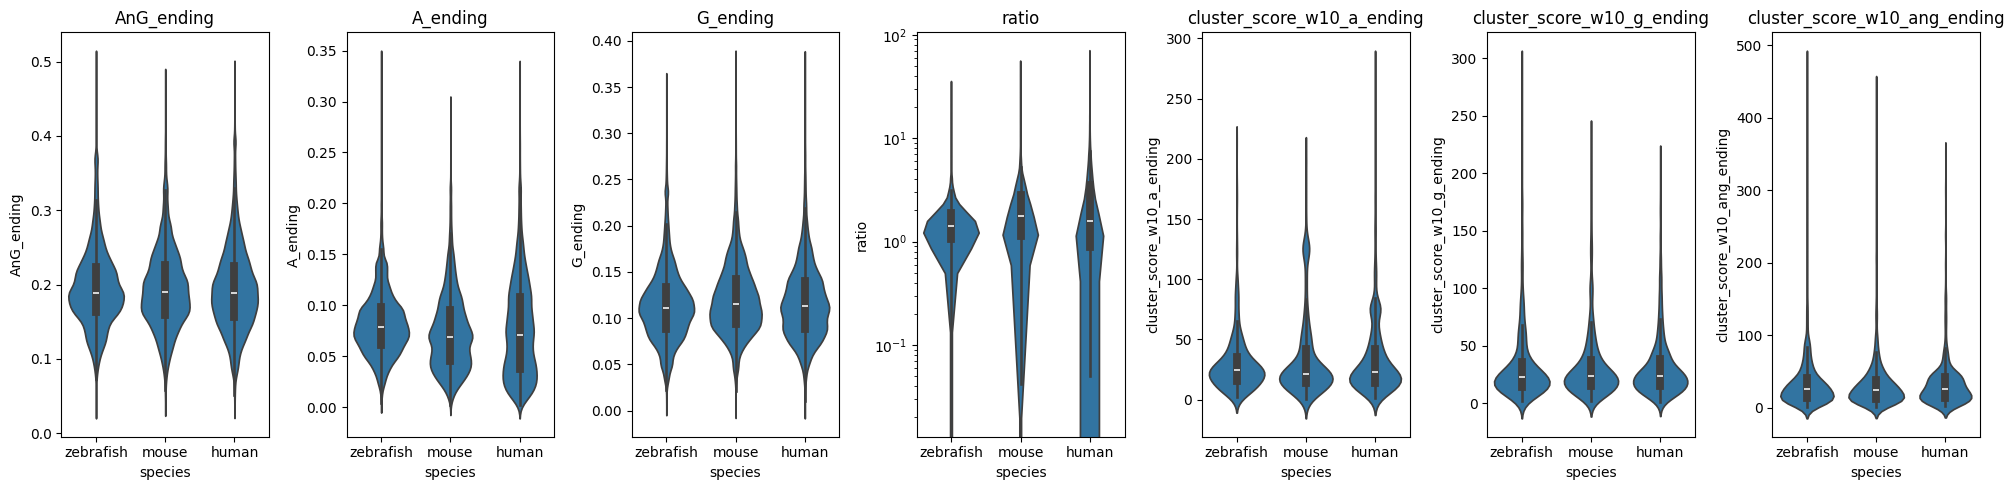

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 7)

for value_col, ax, log_scale in zip(
    [
        'AnG_ending', 'A_ending', 'G_ending', 'ratio', 
        'cluster_score_w10_a_ending', 'cluster_score_w10_g_ending', 
        'cluster_score_w10_ang_ending'
    ], 
    axs, 
    [False, False, False, True, False, False, False]
):
    idx = (
        np.isinf(homologs_with_scores_melt[value_col]) | 
        np.isnan(homologs_with_scores_melt[value_col])
    )
    drop_index = homologs_with_scores_melt[idx].index
    data = homologs_with_scores_melt.drop(
        index = drop_index
    )
    sns.violinplot(
        data = data[data[value_col] > 0],
        x = 'species',
        y = value_col,
        ax = ax
    )
        
    if log_scale:
        ax.set_yscale('log')
        
    ax.set_title(value_col)

fig.set_figwidth(20)
fig.set_figheight(5)
fig.tight_layout()

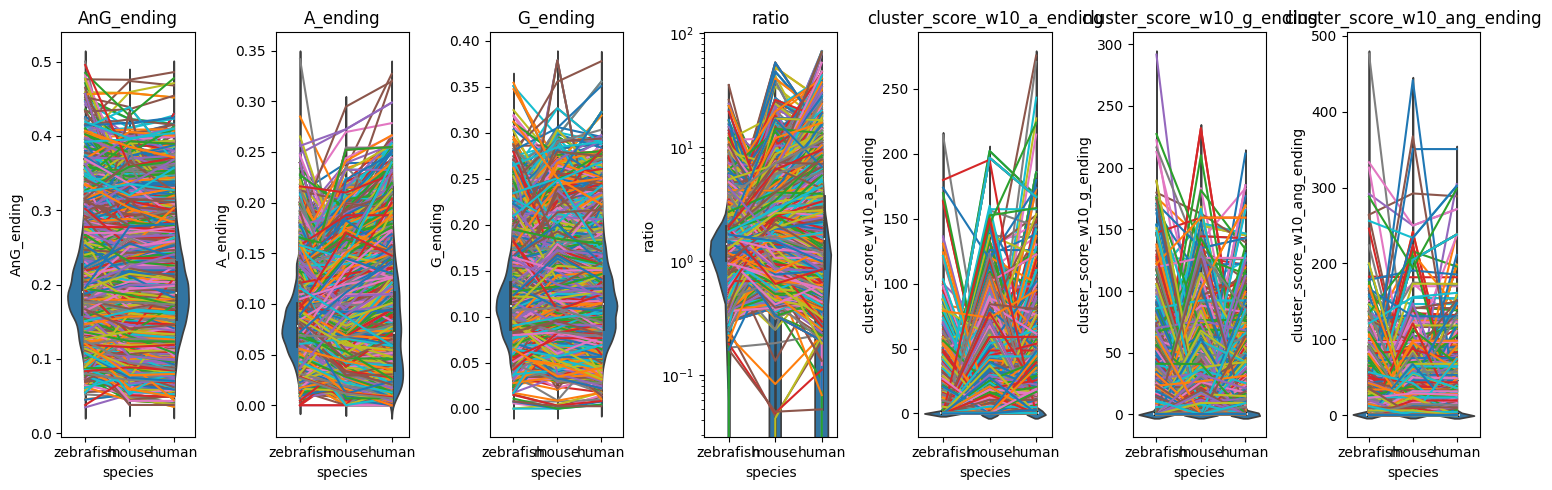

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 7)

for value_col, ax, log_scale in zip(
    [
        'AnG_ending', 'A_ending', 'G_ending', 'ratio', 
        'cluster_score_w10_a_ending', 'cluster_score_w10_g_ending', 
        'cluster_score_w10_ang_ending'
    ], 
    axs, 
    [False, False, False, True, False, False, False]
):
    idx = (
        np.isinf(homologs_with_scores_melt[value_col]) | 
        np.isnan(homologs_with_scores_melt[value_col])
    )
    drop_index = homologs_with_scores_melt[idx].index
    data = homologs_with_scores_melt.drop(
        index = drop_index
    )
    sns.violinplot(
        data = data,
        x = 'species',
        y = value_col,
        ax = ax
    )
    
    pivot_table = data.pivot(
        index = [f'transcript_id_{species}' for species in taxons],
        columns = 'species',
        values = value_col
    )
    for _, row in pivot_table.iterrows():
        ax.plot(
            [0, 1, 2],
            [row[species] for species in taxons],
        )
        
    if log_scale:
        ax.set_yscale('log')
        
    ax.set_title(value_col)

fig.set_figwidth(15)
fig.set_figheight(5)
fig.tight_layout()

In [20]:
import numpy as np

score_pivots = {}
for k in ['a_ending', 'g_ending', 'ang_ending']:
    value_col = f'cluster_score_w10_{k}'
    idx = (
        np.isinf(homologs_with_scores_melt[value_col]) | 
        np.isnan(homologs_with_scores_melt[value_col])
    )
    drop_index = homologs_with_scores_melt[idx].index
    data = homologs_with_scores_melt.drop(
        index = drop_index
    )
    score_pivot = data.pivot(
        index = [
            *[f'transcript_id_{species}' for species in taxons],
            *[f'gene_symbol_{species}' for species in taxons]
        ],
        columns = 'species',
        values = value_col
    )
    score_pivots[value_col] = score_pivot

In [21]:
for value_col in ['AnG_ending', 'A_ending', 'G_ending']:
    idx = (
        np.isinf(homologs_with_scores_melt[value_col]) | 
        np.isnan(homologs_with_scores_melt[value_col])
    )
    drop_index = homologs_with_scores_melt[idx].index
    data = homologs_with_scores_melt.drop(
        index = drop_index
    )
    score_pivot = data.pivot(
        index = [
            *[f'transcript_id_{species}' for species in taxons],
            *[f'gene_symbol_{species}' for species in taxons]
        ],
        columns = 'species',
        values = value_col
    )
    score_pivots[f'freq_{value_col}'] = score_pivot

In [22]:
score_pivots['cluster_score_w10_a_ending']

,,,,,species,human,mouse,zebrafish
transcript_id_zebrafish,transcript_id_mouse,transcript_id_human,gene_symbol_zebrafish,gene_symbol_mouse,gene_symbol_human,,,
ENSDART00000000004.5,ENSMUST00000023344.10,ENST00000492406.6,slc35a5,Slc35a5,SLC35A5,0.000000,0.0,0.0
ENSDART00000000069.8,ENSMUST00000021077.4,ENST00000262613.10,slc9a3r1a,Nherf1,NHERF1,0.000000,0.0,0.0
ENSDART00000000070.7,ENSMUST00000044524.16,ENST00000432074.2,dap,Dap,DAP,0.000000,0.0,0.0
ENSDART00000000192.10,ENSMUST00000064091.12,ENST00000263708.7,ptpn4b,Ptpn4,PTPN4,12.944984,0.0,0.0
ENSDART00000000198.10,ENSMUST00000090823.8,ENST00000368913.7,sema6e,Sema6c,SEMA6C,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...
ENSDART00000193925.1,ENSMUST00000170705.8,ENST00000355904.9,gtf2e2,Gtf2e2,GTF2E2,0.000000,0.0,0.0
ENSDART00000193927.1,ENSMUST00000106933.2,ENST00000371069.5,dnajc6,Dnajc6,DNAJC6,0.000000,0.0,0.0
ENSDART00000193954.1,ENSMUST00000021641.8,ENST00000240587.5,tshz3b,Tshz3,TSHZ3,0.000000,0.0,0.0


In [23]:
score_pivots['freq_AnG_ending']

,,,,,species,human,mouse,zebrafish
transcript_id_zebrafish,transcript_id_mouse,transcript_id_human,gene_symbol_zebrafish,gene_symbol_mouse,gene_symbol_human,,,
ENSDART00000000004.5,ENSMUST00000023344.10,ENST00000492406.6,slc35a5,Slc35a5,SLC35A5,0.160000,0.157534,0.131519
ENSDART00000000069.8,ENSMUST00000021077.4,ENST00000262613.10,slc9a3r1a,Nherf1,NHERF1,0.231198,0.238764,0.231169
ENSDART00000000070.7,ENSMUST00000044524.16,ENST00000432074.2,dap,Dap,DAP,0.214634,0.252427,0.273585
ENSDART00000000192.10,ENSMUST00000064091.12,ENST00000263708.7,ptpn4b,Ptpn4,PTPN4,0.210356,0.212513,0.201923
ENSDART00000000198.10,ENSMUST00000090823.8,ENST00000368913.7,sema6e,Sema6c,SEMA6C,0.125649,0.124481,0.148357
...,...,...,...,...,...,...,...,...
ENSDART00000193925.1,ENSMUST00000170705.8,ENST00000355904.9,gtf2e2,Gtf2e2,GTF2E2,0.277397,0.269625,0.269461
ENSDART00000193927.1,ENSMUST00000106933.2,ENST00000371069.5,dnajc6,Dnajc6,DNAJC6,0.173018,0.176471,0.176149
ENSDART00000193954.1,ENSMUST00000021641.8,ENST00000240587.5,tshz3b,Tshz3,TSHZ3,0.207024,0.214418,0.193966


In [30]:
import gseapy as gp


def isna(a):
    index = np.zeros(shape = a.shape, dtype = bool)
    for i, value in enumerate(a):
        if isinstance(value, str):
            continue
        
        if np.isnan(value):
            index[i] = True
        
    return index


top_x_percent = 0.05
results = {}
for species in ['human', 'zebrafish', 'mouse']:
    species_results = {}
    for k, score_pivot in score_pivots.items():
        score_only = score_pivot[score_pivot[species] >= 0]
        n = int(len(score_only) * top_x_percent)
        top_genes = score_only[species].nlargest(n).reset_index().gene_symbol_human.unique()
        top_genes = top_genes[~isna(top_genes)]
        with open(f'../cluster_scores/top_{top_x_percent * 100}p_genes_{species}_{k}.tsv', 'w') as f:
            for gene in top_genes:
                f.write(gene + '\n')
        
        score_only.to_csv(f'../cluster_scores/{k}_scores_{species}.tsv', sep = '\t')
                
        result = gp.enrichr(
            gene_list = list(top_genes),
            gene_sets = [
                'GO_Biological_Process_2023',
                'GO_Cellular_Component_2023',
                'GO_Molecular_Function_2023',
                'MSigDB_Hallmark_2020'
            ]
        )
        species_results[k] = result.results
    
    results[species] = species_results

In [31]:
gs_to_short = {
    k: v 
    for k, v 
    in zip(
        [
                'GO_Biological_Process_2023',
                'GO_Cellular_Component_2023',
                'GO_Molecular_Function_2023',
                'MSigDB_Hallmark_2020'
        ],
        ['GOBP', 'GOCC', 'GOMF', 'MSigHall']
    )
}

with pd.ExcelWriter('../cluster_scores/codon_bias_gsea.xlsx') as writer:
    combined_results = {}
    for species, res_dict in results.items():
        print(species)
        combined_species = {}
        for gene_set, short in gs_to_short.items():
            print(gene_set)
            dfs = {}
            for k, df in res_dict.items():
                print(k)
                filter_idx = (df['Adjusted P-value'] < 0.05) & (df['Gene_set'] == gene_set)
                dfs[k] = df.loc[filter_idx, :].sort_values(by = 'Combined Score', ascending = False).reset_index(drop = True)

            combined = pd.concat(
                dfs,
                names = ['codontype'],
                axis = 1
            )
            combined.to_excel(
                writer,
                sheet_name = f'{species}_{short}'
            )
            combined_species[short] = combined
        
        combined_results[species] = combined_species
            
    
    for score in results['human'].keys():
        if score.startswith('cluster_score'):
            score_key = score.replace('cluster_score', 'cs')
            
        for gene_set, short in gs_to_short.items():
            dfs = {}
            for species in ['human', 'zebrafish', 'mouse']:
                df = results[species][score]
                filter_idx = (df['Adjusted P-value'] < 0.05) & (df['Gene_set'] == gene_set)
                dfs[species] = df.loc[filter_idx, :].sort_values(by = 'Combined Score', ascending = False).reset_index(drop = True)
            
            combined = pd.concat(
                dfs,
                names = ['species'],
                axis = 1
            )
            combined.to_excel(
                writer,
                sheet_name = f'{score_key}_{short}'
            )
    

human
GO_Biological_Process_2023
cluster_score_w10_a_ending
cluster_score_w10_g_ending
cluster_score_w10_ang_ending
freq_AnG_ending
freq_A_ending
freq_G_ending
GO_Cellular_Component_2023
cluster_score_w10_a_ending
cluster_score_w10_g_ending
cluster_score_w10_ang_ending
freq_AnG_ending
freq_A_ending
freq_G_ending
GO_Molecular_Function_2023
cluster_score_w10_a_ending
cluster_score_w10_g_ending
cluster_score_w10_ang_ending
freq_AnG_ending
freq_A_ending
freq_G_ending
MSigDB_Hallmark_2020
cluster_score_w10_a_ending
cluster_score_w10_g_ending
cluster_score_w10_ang_ending
freq_AnG_ending
freq_A_ending
freq_G_ending
zebrafish
GO_Biological_Process_2023
cluster_score_w10_a_ending
cluster_score_w10_g_ending
cluster_score_w10_ang_ending
freq_AnG_ending
freq_A_ending
freq_G_ending
GO_Cellular_Component_2023
cluster_score_w10_a_ending
cluster_score_w10_g_ending
cluster_score_w10_ang_ending
freq_AnG_ending
freq_A_ending
freq_G_ending
GO_Molecular_Function_2023
cluster_score_w10_a_ending
cluster_scor

In [ ]:
combined.loc[:, ('human',)]

In [ ]:
import seaborn as sns
colors = sns.color_palette("rocket_r", 8)
colors

In [ ]:
# this code does not work currently because some other code got lost
# did not have the time to figure it out but also not so important
# was mainly to see which genes in each GO term lie in terms of score
# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(2, 5)
# for i, ax in enumerate(axs.reshape(10)):
#     genes = combined.loc[i, ('cluster_score_w10_a_ending', 'Genes')].split(';')
#     term = combined.loc[i, ('cluster_score_w10_a_ending', 'Term')]
#     score_pivot = score_pivots['cluster_score_w10_a_ending']
#     score_only = score_pivot[score_pivot.human >= 0]
#     n = int(len(score_only) * 0.05)
#     top_genes = score_only.human.nlargest(n).reset_index().loc[:, ['gene_symbol_human', 'human']]
#     top_genes = top_genes.set_index('gene_symbol_human')
#     sanitized_genes = set(top_genes.index) & set(genes)
#     top_genes = top_genes.loc[list(sanitized_genes), :].drop_duplicates().nlargest(25, 'human')

#     x = np.arange(len(top_genes))
#     ax.scatter(x, top_genes['human'], c = colors[2])
#     for xpos, (gene, score) in enumerate(top_genes['human'].items()):
#         ax.text(
#             xpos, 
#             score + 3,
#             gene,
#             ha = 'center',
#             va = 'bottom',
#             rotation = 90
#         )
    
#     ax.set_title(term)
#     ax.set_ylim(0, 250)
#     ax.set_xlabel('gene_rank')
#     ax.set_ylabel('cluster_score_w10_a_ending')
    
# fig.set_figwidth(20)
# fig.set_figheight(8)
# fig.tight_layout()
# fig.savefig('../plots/cluster_score_a_ending_gene_ranks.pdf')

/lisc/user/malzl/.conda/envs/codons/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/lisc/user/malzl/.conda/envs/codons/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(
MainThread: 2025-03-07 15:37:36-INFO-maxp pruned
MainThread: 2025-03-07 15:37:36-INFO-cmap pruned
MainThread: 2025-03-07 15:37:36-INFO-kern dropped
MainT

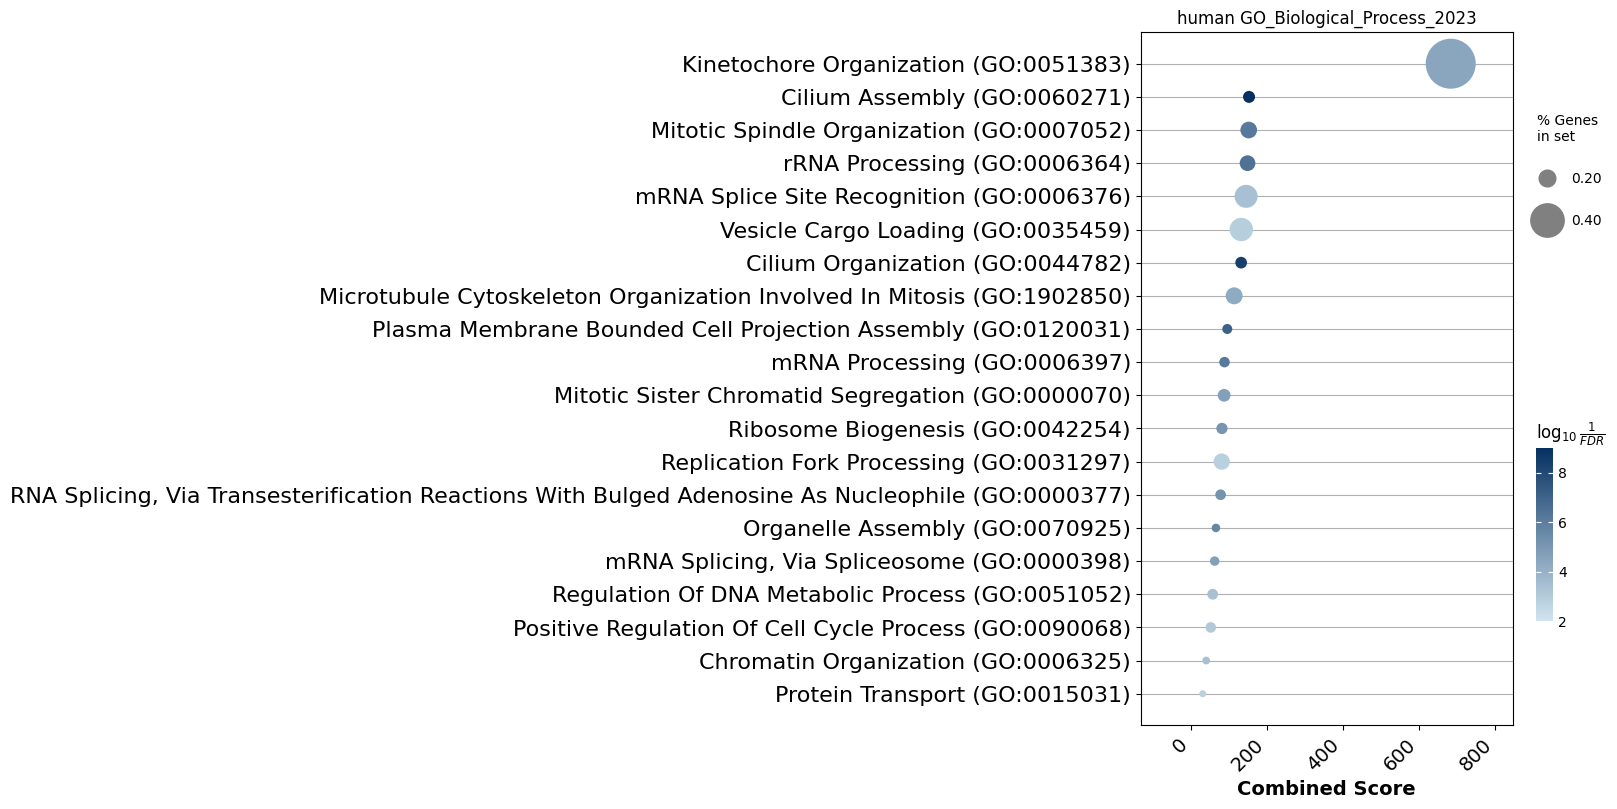

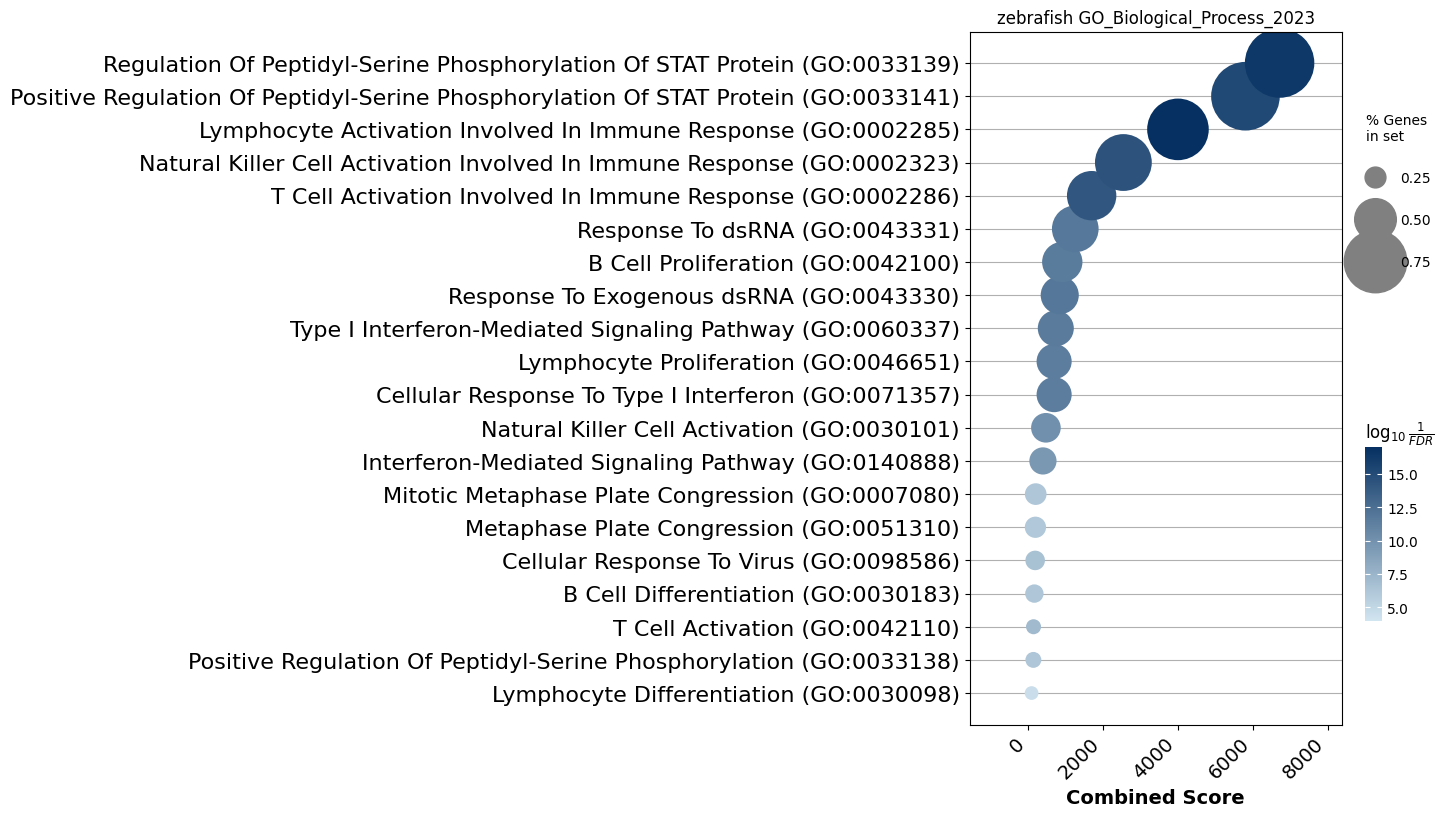

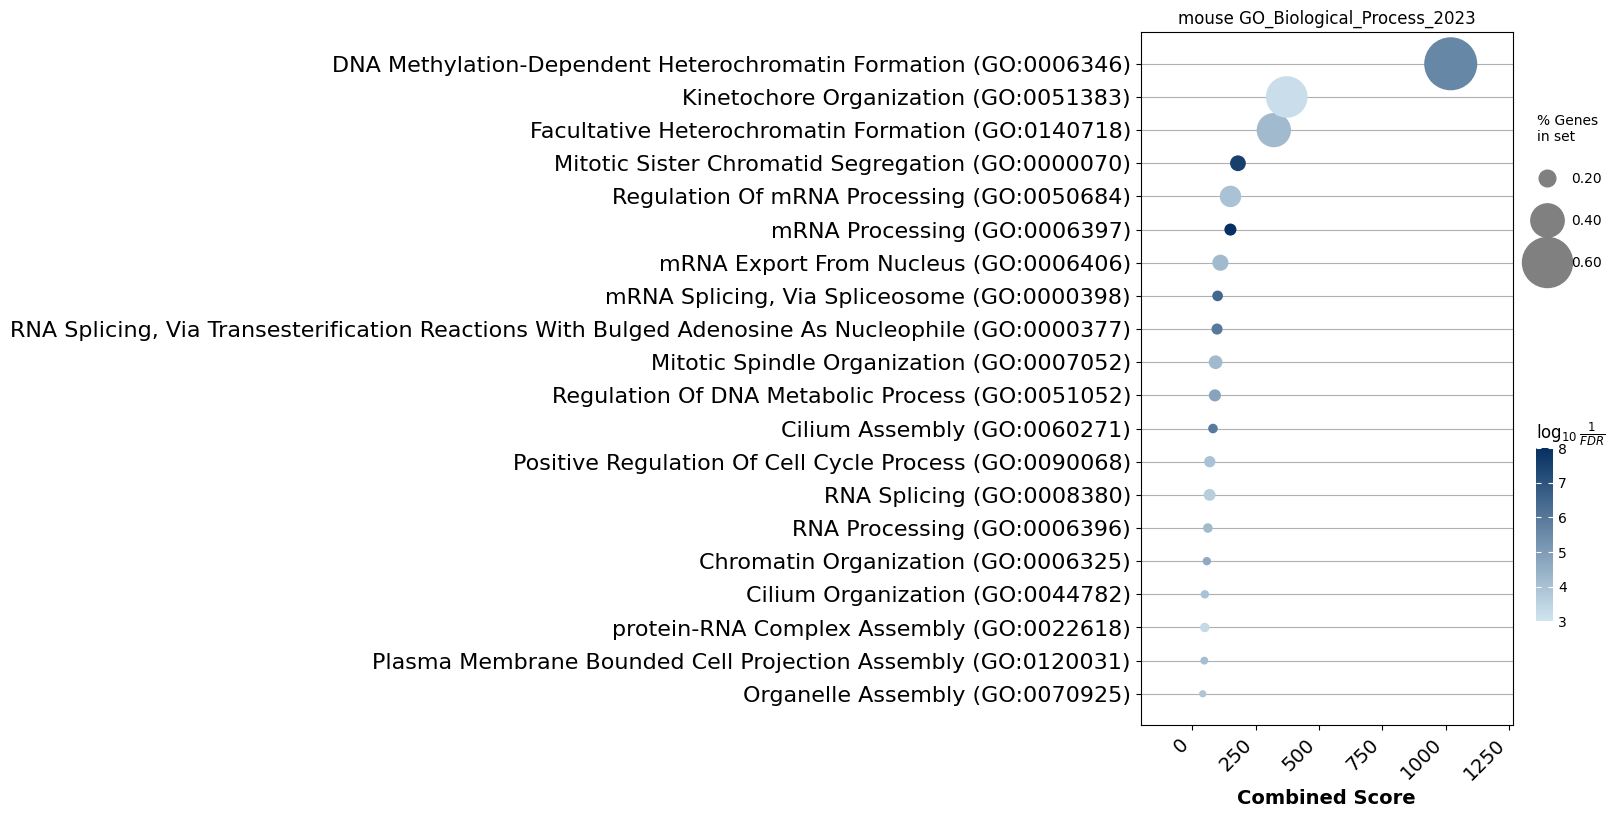

In [39]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('somemap', ['#d1e5f0', '#053061'], N = 256)
# cmap = LinearSegmentedColormap.from_list('somemap', ['#053061', '#f7f7f7', '#67001f', '#fddbc7'], N = 256)
score_key = 'freq_A_ending'
gene_set = 'GO_Biological_Process_2023'
for species in results.keys():
    df = results[species][score_key]
    df = df.loc[df.Gene_set == gene_set, :]
    ax = gp.dotplot(
        df,
        size = 10,
        top_term = 20,
        figsize = (6, 9),
        xticklabels_rot = 45, # rotate xtick labels
        marker = 'o',
        cutoff = 0.1,
        cmap = cmap
    )
    ax.set_title(f'{species} {gene_set}')
    fig = ax.get_figure()
    fig.savefig(f'../plots/dotplot_gsea_{species}_{score_key}_{gene_set}_top20.pdf')

In [40]:
import rbo
import itertools as it

topn = 20
lists = {}
for species in results.keys():
    df = results[species][score_key]
    df = df.loc[df.Gene_set == gene_set, :]
    topn_terms = df.loc[df['Adjusted P-value'].nsmallest(topn).index, :]
    lists[species] = topn_terms.sort_values('Combined Score').Term.values
    
    
for spec1, spec2 in it.combinations(lists.keys(), 2):
    ls1 = set(lists[spec1])
    ls2 = set(lists[spec2])
    print(spec1, spec2, rbo.RankingSimilarity(lists[spec1], lists[spec2]).rbo(p = 1), len(ls1&ls2), len(ls1&ls2)/len(ls1|ls2))

human zebrafish 0.0 0 0.0
human mouse 0.3772166389252303 13 0.48148148148148145
zebrafish mouse 0.0 0 0.0


In [ ]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
venn2(
    (set(lists['human']), set(lists['mouse'])),
    set_labels = ['human', 'mouse'],
    ax = ax
)
ax.set_title('top20 terms freq A ending GOBP')
fig.set_figwidth(8)
fig.set_figheight(4)
fig.tight_layout()
fig.savefig('../plots/top20_GOBP_freqA_human_mouse_overlap.pdf')

In [ ]:
cmap = sns.color_palette("rocket_r", as_cmap=True)

for key in res2ds.keys():
    if not key.startswith('freq'):
        continue
    
    res = results[key]
    for gene_set, df in res.groupby('Gene_set'):
        ax = gp.dotplot(
            df,
            size = 20,
            top_term = 10,
            figsize = (6, 9),
            xticklabels_rot = 45, # rotate xtick labels
            marker = 'o',
            cutoff = 0.1,
            cmap = cmap
        )
        ax.set_title(f'{key} {gene_set}')
        fig = ax.get_figure()
        fig.savefig(f'../plots/dotplot_gsea_{key}_{gene_set}.pdf')